<a href="https://colab.research.google.com/github/Code-Trees/CNN/blob/master/Tiny_image_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')
%autosave 5

Autosaving every 5 seconds


Memory Info

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Module Refresh

In [7]:
def module_refresh():
    import os
    if 'strixbee' in os.listdir():
        os.system("rm -rf strixbee")
        !git clone https://github.com/Code-Trees/strixbee.git
    else:
        !git clone https://github.com/Code-Trees/strixbee.git

In [8]:
module_refresh()

Cloning into 'strixbee'...
remote: Enumerating objects: 767, done.
remote: Counting objects: 100% (767/767), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 767 (delta 490), reused 538 (delta 263), pack-reused 0
Receiving objects: 100% (767/767), 711.34 KiB | 16.17 MiB/s, done.
Resolving deltas: 100% (490/490), done.


All Imports

In [9]:
try:
    #main.py
    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import torch   
    import torch.nn.functional as F
    import torch.nn as nn
    from pytorch_lr_finder import LearningRateFinder

    from torch.optim import SGD
    from torch.utils.data import DataLoader
    from torch.utils.data.dataset import Dataset
    from torch.optim.lr_scheduler import  StepLR,OneCycleLR

    from torchvision import transforms,datasets

    import numpy as np
    import matplotlib.pyplot as plt
    from torchsummary import summary
    import random
    import seaborn as sns
    import gc
    import cv2

    import albumentations as A
    from albumentations.augmentations.geometric.resize import Resize
    from albumentations.pytorch.transforms import ToTensorV2

    from rf_calc import receptive_field
    import seaborn as sns
    import matplotlib.pyplot as plt

    from strixbee.utils.data_iter import get_data,get_data_stats
    from strixbee.utils.data_transforms import AlbumDataset
    from strixbee.utils.optimizer_utils import get_optimizer,run_lrfinder
    from strixbee.utils.train_test import *
    from strixbee.utils.gpu import clean_gpu
    from strixbee.utils.plots import * 
    from strixbee.utils.normalize_utils import * 

    from strixbee.utils import *
    from strixbee.model.custom_layer import *
    from strixbee.model import resnet_custom, resnet
    from strixbee.gradcam import *

    from strixbee.gradcam.visualize import VisualizeCam
except:
    !pip -q install opencv-python
    !pip -q install -U albumentations
    !pip -q  install opencv-python-headless==4.5.2.52
    !pip -q  install Pillow
    !pip -q  install rf_calc
    !pip -q install torch-lr-finder
    !pip -q install pytorch_lr_finder

    import warnings
    warnings.filterwarnings('ignore')

    import numpy as np
    import torch
    import torch.nn.functional as F
    import torch.nn as nn
    from pytorch_lr_finder import LearningRateFinder

    from torch.optim import SGD
    from torch.utils.data import DataLoader
    from torch.utils.data.dataset import Dataset
    from torch.optim.lr_scheduler import  StepLR,OneCycleLR

    from torchvision import transforms,datasets

    import numpy as np
    import matplotlib.pyplot as plt
    from torchsummary import summary
    import random
    import seaborn as sns
    import gc
    import cv2

    import albumentations as A
    from albumentations.augmentations.geometric.resize import Resize
    from albumentations.pytorch.transforms import ToTensorV2

    from rf_calc import receptive_field
    import seaborn as sns
    import matplotlib.pyplot as plt
    import random
    from strixbee.utils.data_iter import get_data,get_data_stats
    from strixbee.utils.data_transforms import AlbumDataset
    from strixbee.utils.optimizer_utils import get_optimizer,run_lrfinder
    from strixbee.utils.train_test import *
    from strixbee.utils.gpu import clean_gpu
    from strixbee.utils.plots import * 
    from strixbee.utils.normalize_utils import * 

    from strixbee.utils import *
    from strixbee.model.custom_layer import *
    from strixbee.model import resnet
    from strixbee.gradcam import *

    from strixbee.gradcam.visualize import VisualizeCam

Data download

In [10]:
train,test = get_data(data = "Tinyimagenet")
print(f"Train Shape: {train.data.shape} Test Shape: {test.data.shape} \n")
labels = train.idx_to_class
# plot_unique_images(train,l = None,b= None,labels =labels)

Files already downloaded and verified
Files already downloaded and verified
Train Shape: (77000, 64, 64, 3) Test Shape: (33000, 64, 64, 3) 



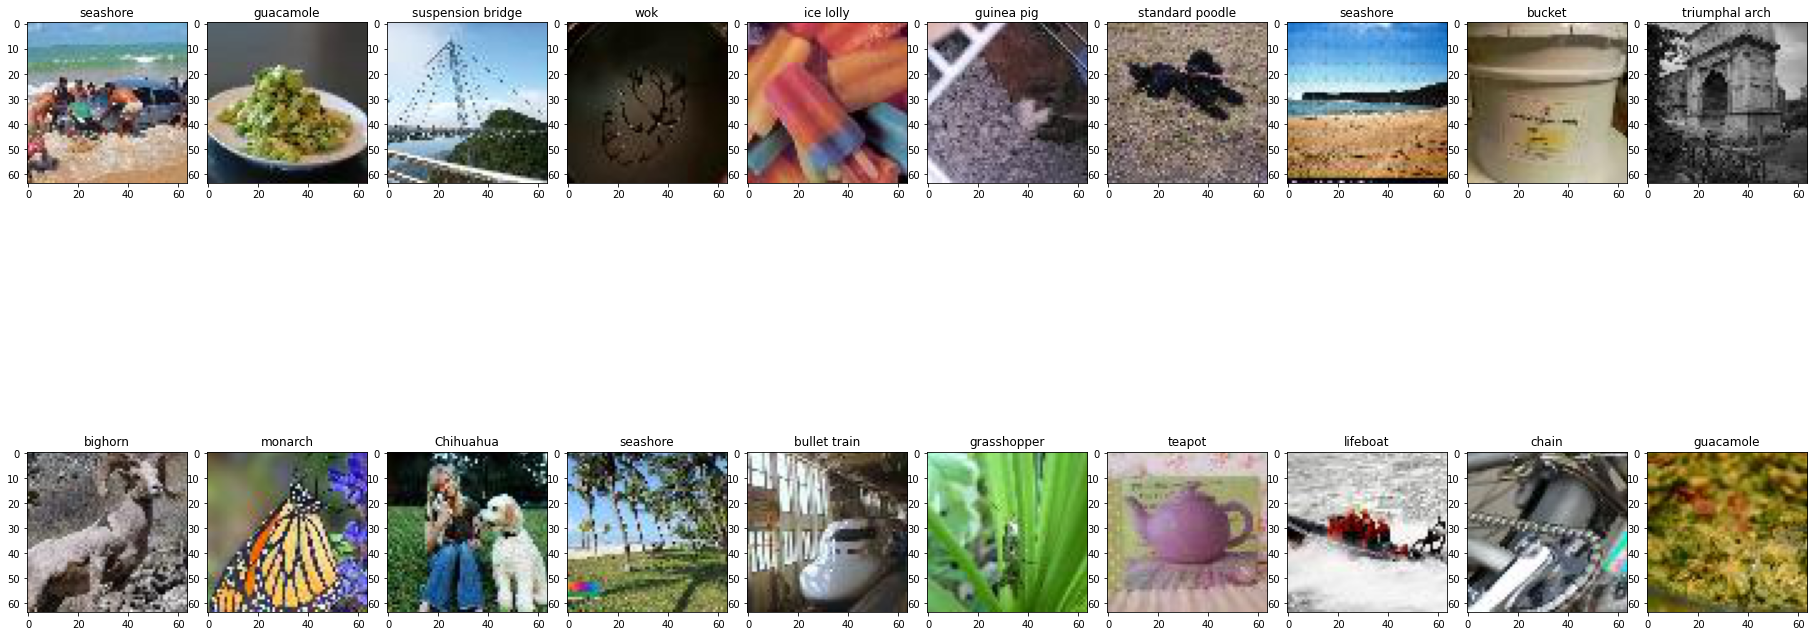

In [11]:
fig = plt.figure(figsize = (2.5*10,2.5*10))
count = 1
for i in range(0,20):
    index = random.choice([i for i in range(0,len(train.targets))])
    # print(index,train.idx_to_class[train.targets[index]])
    ax = fig.add_subplot(2,10,count)
    _=plt.imshow(train.data[index])
    _=plt.title(train.idx_to_class[train.targets[index]])
    _ = plt.autoscale()
    _= fig.tight_layout(pad =0.01,)
    count+=1
plt.show()

Data Distributaiton check

In [12]:
batch_size =64
args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
train_loader = DataLoader(train,batch_size=batch_size,shuffle = True,**args)
test_loader = DataLoader(test,batch_size=batch_size,**args)

In [13]:
# mean,std  = get_data_stats(train,test,img_norm_typ ='train',plot = False)
# print(f"Mean :{mean} , Std :{std}")

In [14]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18_TinyImagenet1():
    return ResNet(BasicBlock, [2,2,2,2], num_classes=200)
# test()

In [15]:
def model_test(model,device):
    net = model.to(device)
    # y = net(torch.randn(1, 3, 32, 32).to(device))
    y = net(torch.randn(1, 3, 64, 64).to(device))
    print("Pass with {} ".format(y.size()))
    return y

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# model1 = resnet_custom.Cifar_Net_R(norm_type = 'bn',drop_out = 0.03).to(device)
model1 = ResNet18_TinyImagenet1().to(device)
# y = model_test(model1,device)
# summary(model1,(3,64,64))

In [17]:
out = model_test(model1,device)
out.shape

Pass with torch.Size([1, 200]) 


torch.Size([1, 200])

In [18]:
train,test = get_data(data = "Tinyimagenet")

#take input as normal_type ['gbn','bn','gn','ln']
mean,std  = get_data_stats(test,train,img_norm_typ ='train',plot = False)

# # Advanced Normalization
# train_transform =A.Compose([A.Resize(32,32),
#                             A.PadIfNeeded (min_height = 40, min_width = 40, border_mode = cv2.BORDER_CONSTANT, value =mean),
#                             A.HorizontalFlip(),
#                             A.CoarseDropout (max_holes=3, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=mean, p=0.8),
#                             A.ShiftScaleRotate (shift_limit = 0.05, scale_limit = 0.1, rotate_limit = 9, p = 0.5,always_apply = False),
#                             A.RandomCrop (height = 32, width = 32, always_apply = False),
#                             A.Normalize (mean =mean, std = std),
#                             ToTensorV2(transpose_mask =False)
#                             ])
train_transform1 =A.Compose([A.Resize(64,64),
                            A.Normalize (mean =mean, std = std),
                            A.ShiftScaleRotate (shift_limit= 0.15, scale_limit= 0.15, rotate_limit= 10, p= 0.3),
                            A.Sequential([A.PadIfNeeded (min_height = 40, min_width = 40, border_mode = cv2.BORDER_CONSTANT, value =mean),
                                          A.RandomCrop(height=64, width=64)
                                          ]),
                            A.HorizontalFlip(p = 0.3),
                            A.CoarseDropout (max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, fill_value=mean, p=0.3),
                            ToTensorV2(transpose_mask =False)
                            ])

# train_transform =A.Compose([A.Resize(32,32),
#                             A.Sequential([A.PadIfNeeded(min_height=36, min_width=36),
#                                             A.RandomCrop(32, 32)
#                                           ]),
#                             A.HorizontalFlip(),
#                             A.Normalize (mean =mean, std = std),
#                             A.Cutout(num_holes=8),
#                             # A.ShiftScaleRotate (shift_limit= 0.15, scale_limit= 0.15, rotate_limit= 10, p= 0.3),
#                             # A.CoarseDropout (max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, fill_value=mean, p=0.3),
#                             ToTensorV2(transpose_mask =False)
#                             ])

test_transform1 = A.Compose([A.Resize(64,64),
                            A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                            ToTensorV2(transpose_mask =False), 
                            ])

train_alb = AlbumDataset(train,train_transform1)
test_alb = AlbumDataset(test,test_transform1)

batch_size =64
args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
train_loader = DataLoader(train_alb,batch_size=batch_size,shuffle = True,**args)
test_loader = DataLoader(test_alb,batch_size=batch_size,**args)

Files already downloaded and verified
Files already downloaded and verified


<Figure size 1080x360 with 0 Axes>

  0%|          | 0/4530 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.76E-01


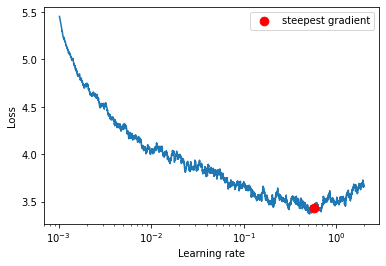

Loss: 3.368688825740557 LR :0.5757210362079892


[0.5757210362079892]

In [ ]:
# start_lr = [ 1e-4,1e-3,1e-2,1e-1,0.1]
# end_lr = [1, 1, 1, 1,1]
start_lr = [0.001]
end_lr =[2]

run_lrfinder(model1,device,train_loader,test_loader,start_lr,end_lr )

In [20]:
def Run_Model(model_class,train_loader,test_loader,epochs, L1 = False,):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print (f'running on {device} \n')
    #take input as normal_type ['gbn','bn','gn','ln']
    model = model_class.to(device)
    try:
        # print(summary(model,input_size = (3,32,32)))
        pass
    except:
        pass
    train_losses = []
    train_accuracy = []
    test_losses =[]
    test_accuracy = []
    lrs = []

    max_lr = 0.5757
    min_lr = max_lr/10
    print("MAX LR: ", max_lr)
    print("MIN LR: ", min_lr)
    

    optimizer = SGD(model.parameters(), lr=min_lr, momentum=0.9,weight_decay = 0.0)
    scheduler = OneCycleLR(optimizer,max_lr=max_lr,steps_per_epoch=2*len(train_loader),epochs = epochs,pct_start=4/24)

    for EPOCHS in range(0,epochs):
        print ("LR :{}\n".format(scheduler.get_last_lr()))
        lrs.append(scheduler.get_last_lr())
        if L1 == True:
            print(f"L1 is {L1}")
            train_loss, train_acc = trainning(model,device,train_loader,optimizer,epochs,)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)
        else:
            train_loss, train_acc = trainning(model,device,train_loader,optimizer,EPOCHS,scheduler = scheduler)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)

        test_loss,test_acc = testing(model,device,test_loader,optimizer,EPOCHS)
        test_accuracy.append(test_acc)
        test_losses.append(test_loss)
        print ( f"{'========================================================='*2}\n")
    
        try:
            if (EPOCHS >=5)&(max(test_accuracy[:-1]) < test_accuracy[-1]) & (max(test_accuracy) >= .50):
                checkpoint = {'epoch': EPOCHS + 1,'valid_loss_min': test_losses[-1],'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),} # Export to TorchScript
                torch.save(checkpoint ,'./Model_cifar10.pt') # Save
                print (f"Achieved: {max(test_accuracy)*100}% Test Accuracy !!")
        except:
            print('Model Saving Failed !!')

        print(f"Best test accuracy {max(test_accuracy)}\n")
    return model,train_losses, train_accuracy,test_losses,test_accuracy,lrs


Files already downloaded and verified
Files already downloaded and verified
running on cuda 

MAX LR:  0.5757
MIN LR:  0.057569999999999996
LR :[0.02302800000000005]



Train ==> Epochs: 0 Batch:  601 loss: 4.562655448913574 Accuracy: 5.57% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 0 Batch:  257 loss: 0.0337031893007683 Accuracy: 8.63% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Model Saving Failed !!
Best test accuracy 0.08633333333333333

LR :[0.027923643218708438]



Train ==> Epochs: 1 Batch:  601 loss: 3.691577911376953 Accuracy: 13.47% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 1 Batch:  257 loss: 0.029308827313509856 Accuracy: 16.59% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Best test accuracy 0.16590909090909092

LR :[0.042437107799527585]



Train ==> Epochs: 2 Batch:  601 loss: 3.534296751022339 Accuracy: 20.33% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 2 Batch:  257 loss: 0.026450352863831954 Accuracy: 23.38% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.23381818181818181

LR :[0.06605414482479888]



Train ==> Epochs: 3 Batch:  601 loss: 2.631371021270752 Accuracy: 26.38% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 3 Batch:  257 loss: 0.024570524150674993 Accuracy: 27.29% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.2729393939393939

LR :[0.09793794267997524]



Train ==> Epochs: 4 Batch:  601 loss: 2.3000166416168213 Accuracy: 31.88% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 4 Batch:  257 loss: 0.023190306584040324 Accuracy: 30.81% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Best test accuracy 0.3080909090909091

LR :[0.13695877741481938]



Train ==> Epochs: 5 Batch:  601 loss: 2.915260076522827 Accuracy: 36.26% : 100%|██████████| 602/602 [02:55<00:00,  3.43it/s]
Test ==> Epochs: 5 Batch:  257 loss: 0.02201337897416317 Accuracy: 34.98% : 100%|██████████| 258/258 [00:24<00:00, 10.62it/s]



Best test accuracy 0.34984848484848485

LR :[0.18173404173272162]



Train ==> Epochs: 6 Batch:  601 loss: 2.4420642852783203 Accuracy: 40.74% : 100%|██████████| 602/602 [02:55<00:00,  3.43it/s]
Test ==> Epochs: 6 Batch:  257 loss: 0.020854596296946207 Accuracy: 37.49% : 100%|██████████| 258/258 [00:24<00:00, 10.62it/s]



Best test accuracy 0.37487878787878787

LR :[0.230677234279361]



Train ==> Epochs: 7 Batch:  601 loss: 2.3466298580169678 Accuracy: 44.68% : 100%|██████████| 602/602 [02:55<00:00,  3.43it/s]
Test ==> Epochs: 7 Batch:  257 loss: 0.019943635492613822 Accuracy: 41.27% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.4126969696969697

LR :[0.28205417341576977]



Train ==> Epochs: 8 Batch:  601 loss: 1.9621607065200806 Accuracy: 48.58% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 8 Batch:  257 loss: 0.019927198164390796 Accuracy: 41.12% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Best test accuracy 0.4126969696969697

LR :[0.33404444367902486]



Train ==> Epochs: 9 Batch:  601 loss: 1.5024433135986328 Accuracy: 52.08% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 9 Batch:  257 loss: 0.019257078597039887 Accuracy: 42.26% : 100%|██████████| 258/258 [00:24<00:00, 10.58it/s]



Best test accuracy 0.4226060606060606

LR :[0.3848058977263761]



Train ==> Epochs: 10 Batch:  601 loss: 1.9503865242004395 Accuracy: 55.22% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 10 Batch:  257 loss: 0.018793303868987345 Accuracy: 44.18% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.44181818181818183

LR :[0.43253992829508026]



Train ==> Epochs: 11 Batch:  601 loss: 1.3645704984664917 Accuracy: 58.28% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 11 Batch:  257 loss: 0.01845830376220472 Accuracy: 45.91% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Best test accuracy 0.4591212121212121

LR :[0.475555197426599]



Train ==> Epochs: 12 Batch:  601 loss: 1.654666781425476 Accuracy: 61.35% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 12 Batch:  257 loss: 0.018991347377950496 Accuracy: 46.18% : 100%|██████████| 258/258 [00:24<00:00, 10.57it/s]



Best test accuracy 0.46184848484848484

LR :[0.5123275648668606]



Train ==> Epochs: 13 Batch:  601 loss: 1.4439939260482788 Accuracy: 64.42% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 13 Batch:  257 loss: 0.018801104115717338 Accuracy: 47.16% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.4716060606060606

LR :[0.5415540922271296]



Train ==> Epochs: 14 Batch:  601 loss: 1.1369965076446533 Accuracy: 67.10% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 14 Batch:  257 loss: 0.01795216573007179 Accuracy: 49.11% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Best test accuracy 0.4910909090909091

LR :[0.5621992094008857]



Train ==> Epochs: 15 Batch:  601 loss: 1.1199665069580078 Accuracy: 69.80% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 15 Batch:  257 loss: 0.019099231004714966 Accuracy: 48.70% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Best test accuracy 0.4910909090909091

LR :[0.5735314074432856]



Train ==> Epochs: 16 Batch:  601 loss: 0.852860689163208 Accuracy: 72.43% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 16 Batch:  257 loss: 0.01909456953496644 Accuracy: 48.80% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Best test accuracy 0.4910909090909091

LR :[0.5756770455852928]



Train ==> Epochs: 17 Batch:  601 loss: 1.0594207048416138 Accuracy: 74.93% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 17 Batch:  257 loss: 0.019889762289596328 Accuracy: 48.93% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Best test accuracy 0.4910909090909091

LR :[0.5753355281460285]



Train ==> Epochs: 18 Batch:  601 loss: 1.042055606842041 Accuracy: 77.18% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 18 Batch:  257 loss: 0.019579701109365983 Accuracy: 50.64% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Achieved: 50.63636363636363% Test Accuracy !!
Best test accuracy 0.5063636363636363

LR :[0.5745854796766019]



Train ==> Epochs: 19 Batch:  601 loss: 0.7529250383377075 Accuracy: 79.35% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 19 Batch:  257 loss: 0.020572871482733523 Accuracy: 49.90% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Best test accuracy 0.5063636363636363

LR :[0.5734279660369297]



Train ==> Epochs: 20 Batch:  601 loss: 0.8287355899810791 Accuracy: 80.83% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 20 Batch:  257 loss: 0.021491704174966524 Accuracy: 49.39% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Best test accuracy 0.5063636363636363

LR :[0.5718646321172317]



Train ==> Epochs: 21 Batch:  601 loss: 0.6126865744590759 Accuracy: 82.60% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 21 Batch:  257 loss: 0.02101654748844378 Accuracy: 50.22% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Best test accuracy 0.5063636363636363

LR :[0.5698976995005515]



Train ==> Epochs: 22 Batch:  601 loss: 0.689948558807373 Accuracy: 84.30% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 22 Batch:  257 loss: 0.021559651876940873 Accuracy: 50.08% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.5063636363636363

LR :[0.5675299633057657]



Train ==> Epochs: 23 Batch:  601 loss: 0.6632638573646545 Accuracy: 85.19% : 100%|██████████| 602/602 [02:55<00:00,  3.43it/s]
Test ==> Epochs: 23 Batch:  257 loss: 0.021574144890814117 Accuracy: 50.83% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Achieved: 50.83333333333333% Test Accuracy !!
Best test accuracy 0.5083333333333333

LR :[0.5647647882155669]



Train ==> Epochs: 24 Batch:  601 loss: 0.651260256767273 Accuracy: 86.51% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 24 Batch:  257 loss: 0.022419851902759438 Accuracy: 50.15% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.5083333333333333

LR :[0.5616061036950653]



Train ==> Epochs: 25 Batch:  601 loss: 0.3646281957626343 Accuracy: 87.42% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 25 Batch:  257 loss: 0.022535309061859594 Accuracy: 50.82% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.5083333333333333

LR :[0.5580583984078039]



Train ==> Epochs: 26 Batch:  601 loss: 0.4687739908695221 Accuracy: 88.14% : 100%|██████████| 602/602 [02:55<00:00,  3.43it/s]
Test ==> Epochs: 26 Batch:  257 loss: 0.02239317267591303 Accuracy: 51.75% : 100%|██████████| 258/258 [00:24<00:00, 10.55it/s]



Achieved: 51.75151515151515% Test Accuracy !!
Best test accuracy 0.5175151515151515

LR :[0.5541267138371224]



Train ==> Epochs: 27 Batch:  601 loss: 0.4904458820819855 Accuracy: 88.82% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 27 Batch:  257 loss: 0.022674155130530848 Accuracy: 51.01% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Best test accuracy 0.5175151515151515

LR :[0.5498166371219328]



Train ==> Epochs: 28 Batch:  601 loss: 0.48200511932373047 Accuracy: 89.58% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 28 Batch:  257 loss: 0.02332618521199082 Accuracy: 51.31% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.5175151515151515

LR :[0.5451342931170896]



Train ==> Epochs: 29 Batch:  601 loss: 0.18302005529403687 Accuracy: 89.94% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 29 Batch:  257 loss: 0.0222444015416232 Accuracy: 51.78% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Achieved: 51.78181818181818% Test Accuracy !!
Best test accuracy 0.5178181818181818

LR :[0.5400863356896363]



Train ==> Epochs: 30 Batch:  601 loss: 0.321865439414978 Accuracy: 90.60% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 30 Batch:  257 loss: 0.023349572972817853 Accuracy: 52.28% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Achieved: 52.275757575757574% Test Accuracy !!
Best test accuracy 0.5227575757575758

LR :[0.5346799382632952]



Train ==> Epochs: 31 Batch:  601 loss: 0.3836253881454468 Accuracy: 90.96% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 31 Batch:  257 loss: 0.02384260513565757 Accuracy: 52.32% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Achieved: 52.31818181818182% Test Accuracy !!
Best test accuracy 0.5231818181818182

LR :[0.528922783624641]



Train ==> Epochs: 32 Batch:  601 loss: 0.43979349732398987 Accuracy: 91.79% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 32 Batch:  257 loss: 0.02396491606307752 Accuracy: 52.37% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Achieved: 52.37272727272727% Test Accuracy !!
Best test accuracy 0.5237272727272727

LR :[0.5228230530054401]



Train ==> Epochs: 33 Batch:  601 loss: 0.5462626218795776 Accuracy: 91.95% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 33 Batch:  257 loss: 0.024142964641253154 Accuracy: 52.63% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Achieved: 52.627272727272725% Test Accuracy !!
Best test accuracy 0.5262727272727272

LR :[0.5163894144566723]



Train ==> Epochs: 34 Batch:  601 loss: 0.23949047923088074 Accuracy: 92.35% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 34 Batch:  257 loss: 0.023968557159105938 Accuracy: 52.30% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Best test accuracy 0.5262727272727272

LR :[0.5096310105307565]



Train ==> Epochs: 35 Batch:  601 loss: 0.24793563783168793 Accuracy: 92.79% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 35 Batch:  257 loss: 0.02374418011939887 Accuracy: 52.73% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Achieved: 52.73030303030303% Test Accuracy !!
Best test accuracy 0.5273030303030303

LR :[0.5025574452894834]



Train ==> Epochs: 36 Batch:  601 loss: 0.5480088591575623 Accuracy: 93.23% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 36 Batch:  257 loss: 0.02468813254616477 Accuracy: 51.93% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Best test accuracy 0.5273030303030303

LR :[0.495178770656118]



Train ==> Epochs: 37 Batch:  601 loss: 0.24019445478916168 Accuracy: 93.41% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 37 Batch:  257 loss: 0.024669217485370057 Accuracy: 52.65% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.5273030303030303

LR :[0.48750547213106665]



Train ==> Epochs: 38 Batch:  601 loss: 0.18483678996562958 Accuracy: 93.68% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 38 Batch:  257 loss: 0.02447179314584443 Accuracy: 53.09% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Achieved: 53.087878787878786% Test Accuracy !!
Best test accuracy 0.5308787878787878

LR :[0.47954845389140727]



Train ==> Epochs: 39 Batch:  601 loss: 0.4297727346420288 Accuracy: 93.75% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 39 Batch:  257 loss: 0.024808933489250413 Accuracy: 53.25% : 100%|██████████| 258/258 [00:24<00:00, 10.58it/s]



Achieved: 53.25151515151515% Test Accuracy !!
Best test accuracy 0.5325151515151515

LR :[0.4713190232954572]



Train ==> Epochs: 40 Batch:  601 loss: 0.2675092816352844 Accuracy: 94.05% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 40 Batch:  257 loss: 0.02493980364366011 Accuracy: 53.01% : 100%|██████████| 258/258 [00:24<00:00, 10.62it/s]



Best test accuracy 0.5325151515151515

LR :[0.4628288748143979]



Train ==> Epochs: 41 Batch:  601 loss: 0.17867976427078247 Accuracy: 94.42% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 41 Batch:  257 loss: 0.02500449242736354 Accuracy: 53.64% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Achieved: 53.64242424242425% Test Accuracy !!
Best test accuracy 0.5364242424242425

LR :[0.45409007341379193]



Train ==> Epochs: 42 Batch:  601 loss: 0.18772746622562408 Accuracy: 94.79% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 42 Batch:  257 loss: 0.024886693911118942 Accuracy: 53.71% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Achieved: 53.7060606060606% Test Accuracy !!
Best test accuracy 0.537060606060606

LR :[0.4451150374086065]



Train ==> Epochs: 43 Batch:  601 loss: 0.3634518086910248 Accuracy: 94.95% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 43 Batch:  257 loss: 0.02444497340375727 Accuracy: 53.78% : 100%|██████████| 258/258 [00:24<00:00, 10.56it/s]



Achieved: 53.78181818181819% Test Accuracy !!
Best test accuracy 0.5378181818181819

LR :[0.4359165208161082]



Train ==> Epochs: 44 Batch:  601 loss: 0.18306708335876465 Accuracy: 95.01% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 44 Batch:  257 loss: 0.024889288797523036 Accuracy: 53.93% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Achieved: 53.93030303030303% Test Accuracy !!
Best test accuracy 0.5393030303030303

LR :[0.4265075952317073]



Train ==> Epochs: 45 Batch:  601 loss: 0.11250519752502441 Accuracy: 95.23% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 45 Batch:  257 loss: 0.02511729035955487 Accuracy: 53.60% : 100%|██████████| 258/258 [00:24<00:00, 10.61it/s]



Best test accuracy 0.5393030303030303

LR :[0.4169016312535042]



Train ==> Epochs: 46 Batch:  601 loss: 0.14614856243133545 Accuracy: 95.47% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 46 Batch:  257 loss: 0.02530446537335714 Accuracy: 53.91% : 100%|██████████| 258/258 [00:24<00:00, 10.60it/s]



Best test accuracy 0.5393030303030303

LR :[0.4071122794819391]



Train ==> Epochs: 47 Batch:  601 loss: 0.15993689000606537 Accuracy: 95.46% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 47 Batch:  257 loss: 0.025474593711621835 Accuracy: 54.18% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Achieved: 54.17878787878788% Test Accuracy !!
Best test accuracy 0.5417878787878788

LR :[0.3971534511215412]



Train ==> Epochs: 48 Batch:  601 loss: 0.219365194439888 Accuracy: 95.76% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 48 Batch:  257 loss: 0.02587630479263537 Accuracy: 53.61% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]



Best test accuracy 0.5417878787878788

LR :[0.387039298212346]



Train ==> Epochs: 49 Batch:  601 loss: 0.055596403777599335 Accuracy: 95.76% : 100%|██████████| 602/602 [02:55<00:00,  3.42it/s]
Test ==> Epochs: 49 Batch:  257 loss: 0.02627350354194641 Accuracy: 54.12% : 100%|██████████| 258/258 [00:24<00:00, 10.59it/s]


Best test accuracy 0.5417878787878788



<Figure size 1080x360 with 0 Axes>

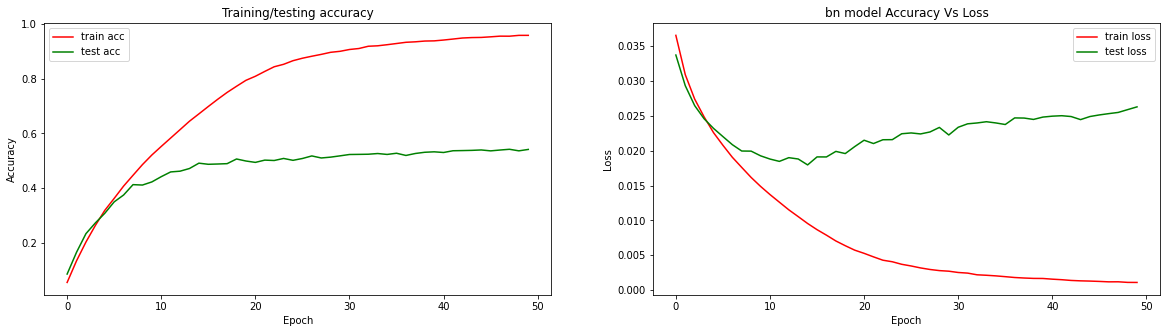

KeyError: ignored

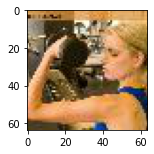

In [22]:
if __name__ == "__main__":
    batch_size = 128
    epochs =50  

    _=torch.manual_seed(1)
    if torch.cuda.is_available():
        _=torch.cuda.manual_seed(1)

    train,test = get_data(data = "Tinyimagenet")
    #take input as normal_type ['gbn','bn','gn','ln']
    # To Un Normalize the test data
    mean,std  = get_data_stats(test,train,img_norm_typ ='train',plot = False)
    
    # # Advanced Normalization
    train_transform =A.Compose([A.Resize(64,64),
                                A.Normalize (mean =mean, std = std),
                                A.ShiftScaleRotate (shift_limit= 0.15, scale_limit= 0.15, rotate_limit= 10, p= 0.3),
                                A.Sequential([A.PadIfNeeded (min_height = 40, min_width = 40, border_mode = cv2.BORDER_CONSTANT, value =mean),
                                            A.RandomCrop(height=64, width=64)
                                            ]),
                                A.HorizontalFlip(p = 0.3),
                                A.CoarseDropout (max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=8, min_width=8, fill_value=mean, p=0.3),
                                ToTensorV2(transpose_mask =False)
                                ])
            
    test_transform = A.Compose([A.Resize(64,64),
                               A.Normalize(mean = mean,std = std,max_pixel_value=255,always_apply = True),
                               ToTensorV2(transpose_mask =False), ])

    train_alb = AlbumDataset(train,train_transform)
    test_alb = AlbumDataset(test,test_transform)

    args = {'pin_memory':True,'num_workers':4} if torch.cuda.is_available() else {}
    train_loader = DataLoader(train_alb,batch_size=batch_size,shuffle = True,**args)
    test_loader = DataLoader(test_alb,batch_size=batch_size,**args)

    # ['gbn','bn','gn','ln']
    try_type = ['bn']

    for norm_type in try_type:

        model_class =ResNet18_TinyImagenet1().to(device)
        # model_class = ResNetCustom().to(device)

        model,train_losses, train_accuracy,test_losses,test_accuracy,lrs = Run_Model(model_class,train_loader,test_loader,epochs =epochs)

        plot_acc_loss(norm_type ,train_accuracy,train_losses,test_accuracy,test_losses)
        clean_gpu()

        wrong_images,wrong_labels,right_labels = print_wrong_image(model,test_loader,mean,std,2,5)
        clean_gpu()

        num_img = 20
        correct_pred_imgs = []
        count = 0

        for i in range(num_img):
            correct_pred_imgs.append(torch.as_tensor(random.choice(wrong_images)))

        # target_layers = ["layer1","layer2","layer3","layer4"]
        # viz_cam = VisualizeCam(model,[labels[i] for i in range(0,10)], target_layers)
        # viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="worng")

KeyError: ignored

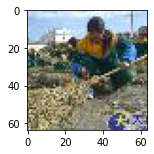

In [23]:
wrong_images,wrong_labels,right_labels = print_wrong_image(model,test_loader,mean,std,2,5)
clean_gpu()

num_img = 20
correct_pred_imgs = []
count = 0

for i in range(num_img):
    correct_pred_imgs.append(torch.as_tensor(random.choice(wrong_images)))

# target_layers = ["layer1","layer2","layer3","layer4"]
# viz_cam = VisualizeCam(model,[labels[i] for i in range(0,10)], target_layers)
# viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="worng")

In [24]:
def convert_image_np(inp,mean,std):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp
    

In [61]:
def print_wrong_image1(model,label,data_loader,mean,std,l,b):

    if l*b >= 30:
        n_images = 50
    
    labels = label
    wrong_images = []
    wrong_labels = []
    right_labels = []
    val = []
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for data,label in data_loader:
        data,label = data.to(device),label.to(device)
        # _=plt.imshow(np.transpose(data[16].to("cpu"),(1,2,0)))
        # _=plt.xlabel(f"Act:{labels[label[16].item()]} \n  ")
        with torch.no_grad():
            out = model(data)
            wrong_idx = (out.to(device).argmax(dim = 1).eq(label.to(device)) ==False)
            val.extend(out[wrong_idx].to("cpu").max(axis = 1)[0])
            wrong_images.extend(data[wrong_idx].to("cpu"))
            wrong_labels.extend(out[wrong_idx].argmax(dim = 1).to("cpu"))
            right_labels.extend(label[wrong_idx].to("cpu"))

    wrong_idx = [i for i in range(0,len(wrong_images))]
    idx = [i for i in range(0,len(wrong_labels))]
    np.random.shuffle(wrong_idx)
    fig = plt.figure(figsize=(2.5*b,5*l))
    count = 1
    for image_index in wrong_idx:
        n= image_index
        ax = fig.add_subplot(l,b,count)
        # plt.imshow(np.array(np.transpose(data[10].to("cpu"),(1,2,0))))
        img_x = convert_image_np(wrong_images[image_index],mean,std)
        _=plt.imshow(img_x)
        # _=plt.title(f"wrong Images")
        try:
            _=plt.xlabel(f"Act:{labels[right_labels[image_index].item()]} \n Pred: {labels[wrong_labels[image_index].item()]} \n Val: {val[image_index].item()}")
        except:
            pass
        # print(image_index)
        # # print(f"Act:{labels[right_labels[image_index].item()]}\n")
        # print(f"\n Pred: {labels[wrong_labels[image_index].item()]}")
        # print(f"\n Val: {val[image_index].item()}")
        
        fig.tight_layout(pad = 0.5)
        count+= 1
        if count== (l*b)+1:
            break
    _ = plt.autoscale()
    _= plt.show()
    return wrong_idx,val,wrong_images,wrong_labels,right_labels

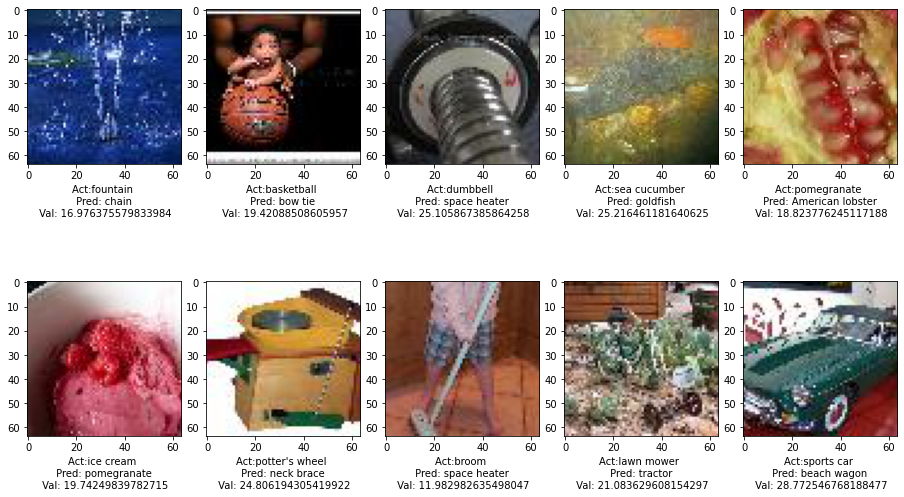

In [62]:
wrong_idx,val,wrong_images,wrong_labels,right_labels = print_wrong_image1(model,labels,test_loader,mean,std,2,5)

In [ ]:
labels

In [63]:
viz_cam = VisualizeCam(model, [labels[i] for i in range(0,10)],target_layers)
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="worng")

NameError: ignored